In [1]:
#-*-coding:utf-8-*-

%load_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torchvision

import cv2

import copy

import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
%matplotlib inline

__ROOT_PATH = os.path.abspath('../../')
sys.path.append(__ROOT_PATH)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
matplotlib.rcParams['figure.facecolor'] = 'w'

In [2]:
from csgan.loader.colored_mnist_loader import ColoredMnistDataset
from csgan.model.cs_glow_model_huk import CSGlowMnistModel

In [6]:
#DATA_ROOT = os.path.join(__ROOT_PATH, "data/")
DATA_ROOT = '/data'
RUN_ROOT = os.path.join(__ROOT_PATH, "runs/")

In [7]:
run_dir = os.path.join(RUN_ROOT, "mnist_cs_glow/")
os.makedirs(run_dir, exist_ok=True)

params = {'seed': 2222, 'num_epoch': 200, 'batch_size': 16, 'test_batch_size': 512,
          'learning_rate': 0.0001, 'beta1': 0.5, 'beta2': 0.999,
          'scheduler_gamma': 1., 'weight_decay': 0., #0.00001,
          'n_bits': 5,
          'lambda_identity': 0., 'lambda_glow': 1.,
          'lambda_weight_cycle': 0., 'lambda_siamese': 0.,
          'lambda_content': 0., 'lambda_style': 0.,
          'gamma_content': 1., 'gamma_style': 1.,
          'scheduler_interval': 1000, 'checkpoint_interval': 10,
          'validation_interval': 10, 'logging_interval': 10, 'sampling_interval': 100,
          'stopping_loss': 'loss',
          'run_dir': run_dir}

In [8]:
train_dataset = ColoredMnistDataset(root=DATA_ROOT, dirname='colored_mnist_bg', train=True)
test_dataset = ColoredMnistDataset(root=DATA_ROOT, dirname='colored_mnist_bg', train=False)
print(len(train_dataset), len(test_dataset))

60000 10000


In [9]:
train_loader = DataLoader(train_dataset, params['batch_size'], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, params['test_batch_size'], shuffle=False, drop_last=False)
print(len(train_loader), len(test_loader))

3750 20


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cs_model = CSGlowMnistModel(device)
#cs_model.load(os.path.join(run_dir, 'best_model.pth.tar'))
cs_model.train_model(train_loader, params=params)

/home/mhjeon/style-content-gan/csgan/deep/glow/model.py:108: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378098133/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  w_s = torch.from_numpy(w_s)



Learning with learning rate:  0.00010000.

[1/200] 10'th step. [LOSS] 3.788378. [LOSS_IDENTITY] 0.000000. [LOSS_GLOW] 3.788378. [LOSS_WEIGHT_CYCLE] 0.000000. [LOSS_CONTENT] 0.000000. [ACCURACY_CONTENT] 0.500000. [LOSS_STYLE] 0.000000. [ACCURACY_STYLE] 0.500000. [LOSS_SIAMESE] 0.000000. [NORM_S1] 1.749133. [NORM_S2] 1.782599
    Best Step:     10. Elapsed Time: 46.316743 seconds.
[1/200] 20'th step. [LOSS] 3.544308. [LOSS_IDENTITY] 0.000000. [LOSS_GLOW] 3.544308. [LOSS_WEIGHT_CYCLE] 0.000000. [LOSS_CONTENT] 0.000000. [ACCURACY_CONTENT] 0.500000. [LOSS_STYLE] 0.000000. [ACCURACY_STYLE] 0.500000. [LOSS_SIAMESE] 0.000000. [NORM_S1] 1.561395. [NORM_S2] 1.443165
    Best Step:     20. Elapsed Time: 80.091602 seconds.
[1/200] 30'th step. [LOSS] 3.496843. [LOSS_IDENTITY] 0.000000. [LOSS_GLOW] 3.496843. [LOSS_WEIGHT_CYCLE] 0.000000. [LOSS_CONTENT] 0.000000. [ACCURACY_CONTENT] 0.500000. [LOSS_STYLE] 0.000000. [ACCURACY_STYLE] 0.500000. [LOSS_SIAMESE] 0.000000. [NORM_S1] 1.447382. [NORM_S2] 1.38

/home/mhjeon/anaconda3/envs/pytorch3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Learning with learning rate:  0.00010000.

[1/200] 1000'th step. [LOSS] 2.197885. [LOSS_IDENTITY] 0.000000. [LOSS_GLOW] 2.197885. [LOSS_WEIGHT_CYCLE] 0.000000. [LOSS_CONTENT] 0.000000. [ACCURACY_CONTENT] 0.500000. [LOSS_STYLE] 0.000000. [ACCURACY_STYLE] 0.500000. [LOSS_SIAMESE] 0.000000. [NORM_S1] 2.615498. [NORM_S2] 2.550609
    Best Step:   1000. Elapsed Time: 3470.755687 seconds.
[1/200] 1010'th step. [LOSS] 2.412720. [LOSS_IDENTITY] 0.000000. [LOSS_GLOW] 2.412720. [LOSS_WEIGHT_CYCLE] 0.000000. [LOSS_CONTENT] 0.000000. [ACCURACY_CONTENT] 0.500000. [LOSS_STYLE] 0.000000. [ACCURACY_STYLE] 0.500000. [LOSS_SIAMESE] 0.000000. [NORM_S1] 2.764343. [NORM_S2] 3.139794
    Best Step:   1010. Elapsed Time: 3513.890834 seconds.
[1/200] 1020'th step. [LOSS] 2.159670. [LOSS_IDENTITY] 0.000000. [LOSS_GLOW] 2.159670. [LOSS_WEIGHT_CYCLE] 0.000000. [LOSS_CONTENT] 0.000000. [ACCURACY_CONTENT] 0.500000. [LOSS_STYLE] 0.000000. [ACCURACY_STYLE] 0.500000. [LOSS_SIAMESE] 0.000000. [NORM_S1] 2.677258. [NOR

In [ ]:
all_input, all_output = cs_model.predict(test_loader)

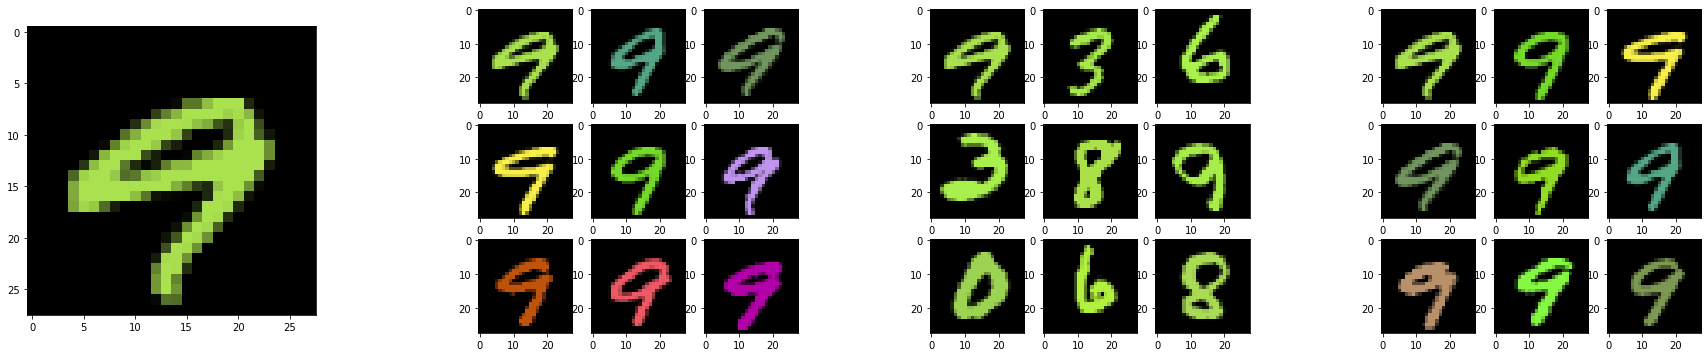

In [11]:
images = all_input['x2'].numpy().transpose(0, 2, 3, 1)
latents = all_output['z2'].numpy()
styles = all_output['s2'].numpy()
contents = all_output['c2'].numpy()

index = np.random.randint(len(images))

fig = plt.figure(figsize=(30, 6))

ax = fig.add_subplot(1, 5, 1)
ax.imshow(images[index])
content_indices = ((contents-contents[index:index+1])**2).mean(axis=1).argsort(axis=0)
style_indices = ((styles-styles[index:index+1])**2).mean(axis=1).argsort(axis=0)
latent_indices = ((latents-latents[index:index+1])**2).mean(axis=1).argsort(axis=0)
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+5)
    ax.imshow(images[content_indices[i]])
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+9)
    ax.imshow(images[style_indices[i]])
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+13)
    ax.imshow(images[latent_indices[i]])

plt.savefig(os.path.join(__ROOT_PATH, "./results/", f"similar_test.png"), dpi=200, bbox_inches='tight')
plt.show()

In [8]:
4/89*100

4.49438202247191